# Authenticate

In [41]:
import sagemaker
from sagemaker.pytorch import PyTorchModel
from sagemaker.model import Model

# aws_role = get_execution_role()
aws_role = "arn:aws:iam::207285235248:role/service-role/AmazonSageMaker-ExecutionRole-20230327T105210"
aws_region = "us-west-2"
session = sagemaker.Session()

print(aws_role)
print(aws_region)
print(session)

arn:aws:iam::207285235248:role/service-role/AmazonSageMaker-ExecutionRole-20230327T105210
us-west-2


# Prepare model

In [42]:
from torchvision.models import resnet50, ResNet50_Weights
import torch
import tarfile

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.eval()

model_file_name = "resnet.pt"
model_archive_name = "model.tar.gz"

traced_script_module = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
traced_script_module.save(model_file_name)

# Then, compress it into a tar.gz file
with tarfile.open(model_archive_name, "w:gz") as tar:
    tar.add(model_file_name)

upload_path = session.upload_data(path='model.tar.gz', bucket='anthony-test-bucket-2', key_prefix='sagemaker_models/resnet50-3')
print(f"Model artifact uploaded to: {upload_path}")

Model artifact uploaded to: s3://anthony-test-bucket-2/sagemaker_models/resnet50-3/model.tar.gz


# Dowload requirements

In [43]:
# pip commands

! mkdir -p code 
! bash -c "virtualenv ./code/.venv && source ./code/.venv/bin/activate && pip install whylogs[image,proc]==1.3.4.dev3 && pip freeze > code/requirements.txt"
! rm -rf ./code/.venv

created virtual environment CPython3.10.11.final.0-64 in 63ms
  creator CPython3Posix(dest=/home/anthony/workspace/sagemaker-example/code/.venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/home/anthony/.local/share/virtualenv)
    added seed packages: pip==23.1.2, setuptools==67.7.2, wheel==0.40.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
  Using cached whylogs-1.3.4.dev3-py3-none-any.whl (1.9 MB)
  Using cached platformdirs-3.10.0-py3-none-any.whl (17 kB)
  Using cached protobuf-4.24.3-cp37-abi3-manylinux2014_x86_64.whl (311 kB)
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached types_requests-2.31.0.3-py3-none-any.whl (14 kB)
  Using cached typing_extensions-4.8.0-py3-none-any.whl (31 kB)
  Using cached whylabs_client-0.5.7-py3-none-any.whl (401 kB)
  Using cached whylogs_sketching-3.4.1.d

# Create inference.py

In [44]:
%%writefile code/inference.py
import traceback
import torch
import requests
import json

from typing import Dict
from PIL import Image
import whylogs as why
from whylogs.api.logger.experimental.logger.actor.process_rolling_logger import ProcessRollingLogger
from whylogs.api.logger.experimental.logger.actor.time_util import Schedule, TimeGranularity
from whylogs.core.resolvers import Resolver
from whylogs.core.schema import ColumnSchema, DatasetSchema
from whylogs.core.datatypes import DataType
from whylogs.extras.image_metric import ImageMetric, ImageMetricConfig
from whylogs.core.metrics.metrics import Metric

why.init(whylabs_api_key="3QYTCJSgE0.ME8gmCfqmdAd233vet4WuLs4eScPW0Lxwb4jHUglnIyQOXZjx5vLA:org-JpsdM6", default_dataset_id="model-70")
# why.init()

row_name = "image"

class ImageResolver(Resolver):
    def resolve(self, name: str, why_type: DataType, column_schema: ColumnSchema) -> Dict[str, Metric]:
        return {ImageMetric.get_namespace(): ImageMetric.zero(column_schema.cfg)}

schema = DatasetSchema(
    types={row_name: Image.Image}, default_configs=ImageMetricConfig(), resolvers=ImageResolver()
)

logger = ProcessRollingLogger(
    aggregate_by=TimeGranularity.Day,
    write_schedule=Schedule(cadence=TimeGranularity.Minute, interval=5),
    schema=schema
)

logger.start()


def create_class_names():
    url = "https://raw.githubusercontent.com/Lasagne/Recipes/master/examples/resnet50/imagenet_classes.txt"
    response = requests.get(url)
    class_names = response.text.split("\n")
    return {i: class_names[i] for i in range(len(class_names))}


class_names = create_class_names()


def model_fn(model_dir):
    model = torch.jit.load(f"{model_dir}/resnet.pt")
    return model


def input_fn(request_body, request_content_type):
    assert request_content_type == 'application/json'
    body = json.loads(request_body)
    assert 'image' in body

    image = body['image']

    try:
        print(f'Logging images {type(image)}')
        logger.log({row_name: image})  # Log async with whylogs
    except Exception as e:
        print(f"Failed to log image: {e}")
        print(traceback.format_exc())

    image = torch.tensor(image, dtype=torch.float32)
    return image


def predict_fn(input_tensor: torch.Tensor, model: torch.nn.Module):
    """
    Args:
        input_object (torch.Tensor): input image, not normalized
        model (torch.nn.Module): model to use for inference
    """
    img_batch = torch.unsqueeze(input_tensor, 0)
    with torch.no_grad():
        output_tensor = model(img_batch)

    _, predicted_class = torch.max(output_tensor, 1)
    predicted_label = class_names[float(predicted_class.numpy())]

    return predicted_label


def output_fn(prediction, content_type):
    return str(prediction)


Overwriting code/inference.py


# Create a pytorch deployment

In [45]:
sagemaker_model = PyTorchModel(
    source_dir='code',
    entry_point='inference.py',
    # dependencies=['.venv'],
    model_data=upload_path,
    framework_version='2.0',
    py_version='py310',
    role=aws_role,  # assuming this is run in a SageMaker environment
)


In [46]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import StringDeserializer

env = {
    "WHYLABS_API_KEY": "3QYTCJSgE0.ME8gmCfqmdAd233vet4WuLs4eScPW0Lxwb4jHUglnIyQOXZjx5vLA:org-JpsdM6",
    "WHYLABS_DEFAULT_DATASET_ID": "model-70",
}

predictor = sagemaker_model.deploy(initial_instance_count=1, instance_type='ml.m5.large', env=env)
predictor.serializer = JSONSerializer()
predictor.deserializer = StringDeserializer()

--

# Make predictions

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/home/anthony/Downloads/volcano.jpg")

plt.imshow(img)
plt.show()

In [ ]:
preprocess = ResNet50_Weights.DEFAULT.transforms()
img_transformed = preprocess(img)

In [ ]:
import json
model_input = json.dumps({'image':img_transformed.tolist()}).encode('utf-8').strip()
predictor.predict({'image':img_transformed.tolist()}, initial_args={'ContentType': 'application/json'})

'volcano'

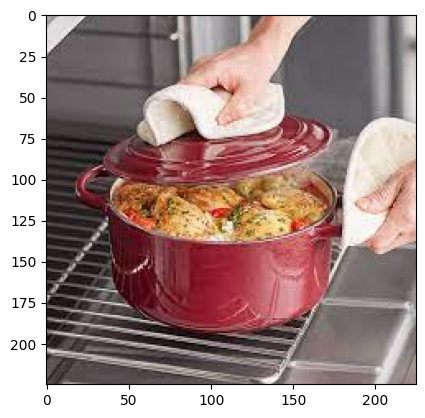

'Dutch oven'

In [ ]:
img = Image.open("/home/anthony/Downloads/dutch_oven.jpeg")

plt.imshow(img)
plt.show()

preprocess = ResNet50_Weights.DEFAULT.transforms()
img_transformed = preprocess(img)

model_input = json.dumps({'image':img_transformed.tolist()}).encode('utf-8').strip()
predictor.predict({'image':img_transformed.tolist()}, initial_args={'ContentType': 'application/json'})

# Clean up endpoint

In [40]:
predictor.delete_endpoint()